In [ ]:
!pip install seaborn

In [1]:
from snowflake.snowpark import Session

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')
import configparser

ModuleNotFoundError: No module named 'seaborn'

# Code to establish connection and read data from Snowflake

In [3]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

['snowflake_connection.ini']

In [4]:
connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    #"password": os.getenv('snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    #"account": os.getenv('snowflake_account'),
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

In [5]:
def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [7]:
application_train_sf  = session.table("CRA_APPLICATION_TRAIN_DETAILS")
application_test_sf  = session.table("CRA_APPLICATION_TEST_DETAILS")
bureau_sf  = session.table("CRA_BUREAU_DETAILS")
bureau_balance_sf  = session.table("CRA_BUREAU_BALANCE_DETAILS")
credit_card_balance_sf  = session.table("CRA_CREDIT_CARD_BALANCE_DETAILS")
installments_payments_sf  = session.table("CRA_INSTALLMENTS_PAYMENTS_DETAILS")
previous_application_sf  = session.table("CRA_PREVIOUS_APPLICATION_DETAILS")
POS_CASH_balance_sf  = session.table("CRA_POS_CASH_BALANCE_DETAILS")

# Convert Snowflake data into Pandas dataframes

In [8]:
application_train = application_train_sf.to_pandas()

In [9]:
application_test = application_test_sf.to_pandas()

In [10]:
bureau = bureau_sf.to_pandas()

In [11]:
bureau_balance = bureau_balance_sf.to_pandas()

In [12]:
credit_card_balance = credit_card_balance_sf.to_pandas()

In [13]:
installments_payments = installments_payments_sf.to_pandas()

In [14]:
previous_application = previous_application_sf.to_pandas()

In [15]:
POS_CASH_balance = POS_CASH_balance_sf.to_pandas()

# Glimpse of Rows and Columns of each dataset

In [16]:
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

application_train -  rows: 307511  columns: 124
application_test -  rows: 48744  columns: 123
bureau -  rows: 1716428  columns: 19
bureau_balance -  rows: 27299925  columns: 5
credit_card_balance -  rows: 3840312  columns: 25
installments_payments -  rows: 13605401  columns: 10
previous_application -  rows: 1670214  columns: 39
POS_CASH_balance -  rows: 10001358  columns: 10


# Sample Data of each dataset

In [17]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREATED_BY,CREATED_AT
0,307660,0,Cash loans,M,Y,Y,0,180000.0,1288350.0,41692.5,...,0,0,0.0,0.0,0.0,0.0,1.0,2.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
1,307662,0,Cash loans,F,N,Y,1,90000.0,93829.5,9981.0,...,0,0,0.0,0.0,0.0,0.0,0.0,4.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
2,307663,0,Cash loans,F,N,Y,0,360000.0,2517300.0,66402.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,manishh.singh@fosfor.com,2024-05-03 06:30:22
3,307664,0,Revolving loans,F,N,N,0,90000.0,270000.0,13500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
4,307665,0,Revolving loans,M,Y,Y,0,225000.0,540000.0,27000.0,...,0,0,0.0,0.0,0.0,0.0,2.0,7.0,manishh.singh@fosfor.com,2024-05-03 06:30:22


In [18]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREATED_BY,CREATED_AT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,manishh.singh@fosfor.com,2024-05-03 06:30:22
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,manishh.singh@fosfor.com,2024-05-03 06:30:22


In [19]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREATED_BY,CREATED_AT
0,279486,6806321,Active,currency 1,-167,0,1659.0,NaN,0.0,0,540000.0,517190.355,0.0,0.0,Consumer credit,-44,0.0,manishh.singh@fosfor.com,2024-05-03 05:19:31
1,116150,6806322,Closed,currency 1,-1273,0,-177.0,-413.0,NaN,0,225000.0,0.000,0.0,0.0,Consumer credit,-383,12172.5,manishh.singh@fosfor.com,2024-05-03 05:19:31
2,116150,6806323,Closed,currency 1,-1539,0,-1358.0,-1357.0,NaN,0,43776.0,0.000,0.0,0.0,Consumer credit,-1357,11070.0,manishh.singh@fosfor.com,2024-05-03 05:19:31
3,116150,6806324,Active,currency 1,-1157,0,-66.0,NaN,NaN,0,225000.0,228523.500,0.0,0.0,Credit card,-76,NaN,manishh.singh@fosfor.com,2024-05-03 05:19:31
4,116150,6806325,Active,currency 1,-446,14,1380.0,NaN,NaN,0,495000.0,412807.500,0.0,220.5,Consumer credit,-16,NaN,manishh.singh@fosfor.com,2024-05-03 05:19:31


In [20]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,CREATED_BY,CREATED_AT
0,5229118,-33,C,manishh.singh@fosfor.com,2024-05-03 05:23:59
1,5229118,-34,C,manishh.singh@fosfor.com,2024-05-03 05:23:59
2,5229118,-35,C,manishh.singh@fosfor.com,2024-05-03 05:23:59
3,5229118,-36,C,manishh.singh@fosfor.com,2024-05-03 05:23:59
4,5229118,-37,C,manishh.singh@fosfor.com,2024-05-03 05:23:59


In [21]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CREATED_BY,CREATED_AT
0,1659971,454441,-31,67.5,45000,0.0,0.0,0.0,0.0,67.5,...,0.0,0,0.0,0.0,47.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:28:17
1,1053462,376931,-33,0.0,180000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,17.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:28:17
2,2628434,183826,-37,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,16.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:28:17
3,1459784,258730,-32,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,16.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:28:17
4,2013969,264511,-32,0.0,180000,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,63.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:28:17


In [22]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,CREATED_BY,CREATED_AT
0,1746757.0,335275.0,1.0,4.0,-810.0,-819.0,31576.860,427946.715,manishh.singh@fosfor.com,2024-05-03 05:35:05
1,1817537.0,312996.0,0.0,26.0,-2485.0,-2500.0,5625.000,5625.000,manishh.singh@fosfor.com,2024-05-03 05:35:05
2,1286167.0,307664.0,1.0,14.0,-1598.0,-1616.0,12563.550,12563.550,manishh.singh@fosfor.com,2024-05-03 05:35:05
3,1900393.0,347451.0,1.0,7.0,-1565.0,-1566.0,4023.810,4023.000,manishh.singh@fosfor.com,2024-05-03 05:35:05
4,1047759.0,338029.0,1.0,5.0,-748.0,-767.0,10326.195,10326.195,manishh.singh@fosfor.com,2024-05-03 05:35:05


In [23]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,CREATED_BY,CREATED_AT
0,2118347,279754,Cash loans,27409.770,247500.0,260896.5,NaN,247500.0,THURSDAY,9,...,middle,Cash X-Sell: middle,365243.0,-1485.0,-1155.0,-1305.0,-1302.0,1.0,manishh.singh@fosfor.com,2024-05-03 05:42:20
1,2676923,221434,Cash loans,7139.655,67500.0,71955.0,NaN,67500.0,SATURDAY,10,...,low_normal,Cash X-Sell: low,365243.0,-1328.0,-998.0,-998.0,-993.0,1.0,manishh.singh@fosfor.com,2024-05-03 05:42:20
2,1861528,361678,Revolving loans,11250.000,225000.0,225000.0,NaN,225000.0,SATURDAY,9,...,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN,manishh.singh@fosfor.com,2024-05-03 05:42:20
3,1553838,312971,Cash loans,26663.220,702000.0,822465.0,NaN,702000.0,FRIDAY,12,...,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN,manishh.singh@fosfor.com,2024-05-03 05:42:20
4,1530560,184883,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,10,...,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN,manishh.singh@fosfor.com,2024-05-03 05:42:20


In [24]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CREATED_BY,CREATED_AT
0,1941489,188651,-77,10.0,6.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:37:47
1,2706308,414084,-79,10.0,1.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:37:47
2,2168928,430842,-75,8.0,0.0,Completed,0,0,manishh.singh@fosfor.com,2024-05-03 05:37:47
3,1556016,410581,-85,10.0,0.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:37:47
4,2366078,290413,-83,8.0,2.0,Active,0,0,manishh.singh@fosfor.com,2024-05-03 05:37:47


# Check Missing Values

In [25]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [26]:
missing_data(application_train).head(10)

,Total,Percent
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
FLOORSMIN_MEDI,208642,67.848630


In [27]:
missing_data(application_test).head(10)

,Total,Percent
COMMONAREA_MODE,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
LIVINGAPARTMENTS_MEDI,32780,67.249302
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302
FLOORSMIN_AVG,32466,66.605121


In [28]:
missing_data(bureau)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
SK_ID_CURR,0,0.000000
CREATED_BY,0,0.000000
DAYS_CREDIT_UPDATE,0,0.000000


In [29]:
missing_data(bureau_balance)

,Total,Percent
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0
CREATED_BY,0,0.0
CREATED_AT,0,0.0


In [30]:
missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_INST_MIN_REGULARITY,305236,7.948208
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
SK_ID_PREV,0,0.000000


In [31]:
missing_data(installments_payments)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000
CREATED_BY,0,0.000000
CREATED_AT,0,0.000000


In [32]:
missing_data(previous_application).head(20)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129


In [33]:
missing_data(POS_CASH_balance)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000
CREATED_BY,0,0.000000
CREATED_AT,0,0.000000


# Check Data Unbalance

NameError: name 'sns' is not defined

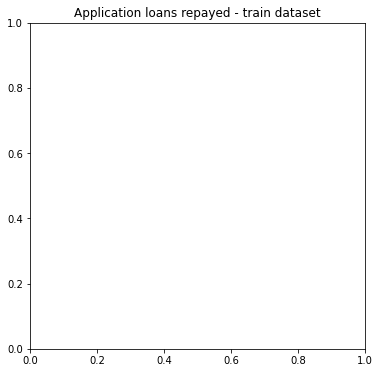

In [34]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()